# NOAA Dataset: Significant Wave Height Prediction

In oceanography and maritime engineering, accurately predicting the height of significant waves is important. It has major impacts on the safety of coastal infrastructure, the generation of renewable energy, and the planning of operations at sea. The usual way to deal with this problem is to use previous data and weather data like wind speed, air pressure, and temperature. This project is making a predictive model like this one for significant wave height data collected by the NOAA 46041 buoy.

However, a first look at the dataset shows that there is a basic conflict between two different, competing predictive signals. So, the main goal of this work is to make a good model by figuring out how these two signals affect each other:

- **Autoregressive Signal:** This comes from inside the system itself. Significant wave height has a lot of autocorrelation, which means that the value at any given time is very much affected by its value in the recent past. This makes a strong but possibly misleading signal that suggests a simple "persistence" model could work very well.

- **Meteorological Signal:** The second signal comes from outside and shows the physical drivers that need to be modeled. The main idea behind any physics-based model is that changes in weather variables like wind speed, atmospheric pressure, and others hold the key to predicting how the sea state will change, no matter what it was like before.

Two things about the dataset that are built in make this project even harder because they have a significant effect on these signals. First, the wave height data is very quantized, which means that it is reported in separate steps instead of as a continuous variable. This makes the autoregressive signal seem "stickier" than it really is, which in turn makes the sea state seem more stable than it really is and could hide small changes. Second, the data only covers a month, which may not be enough time to see all the different types of weather that are needed to find a strong, generalizable link between meteorological forces and wave height.

## Setup and Data Loading

In [21]:
import os
import itertools
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [5]:
df = pd.read_csv('../data/clean/NOAA_complete.csv',
                 parse_dates=['date_time'], index_col='date_time')
df = df.sort_index().asfreq('h')
df.index.freq = 'h'

df.head()

,latitude_degrees_north,longitude_degrees_east,air_temperature_celsius,sea_level_pressure_hpa,gust_speed_mps,significant_wave_height_m,dominant_wave_period_s,sea_surface_temperature_celsius,wind_speed,buoy2_wind_speed,buoy3_wave_height
date_time,,,,,,,,,,,
2013-04-18 00:50:00+00:00,47.348999,-124.708,7.2,1032.599976,8.0,1.0,8.0,10.1,5.0,5.4,1.1
2013-04-18 01:50:00+00:00,47.348999,-124.708,6.8,1032.300049,5.0,1.1,6.0,10.0,4.0,5.1,1.2
2013-04-18 02:50:00+00:00,47.348999,-124.708,6.9,1031.800049,4.0,1.1,7.0,10.0,3.0,5.2,1.0
2013-04-18 03:50:00+00:00,47.348999,-124.708,7.0,1031.699951,3.0,1.0,6.0,9.9,2.0,5.8,1.1
2013-04-18 04:50:00+00:00,47.348999,-124.708,7.1,1031.900024,2.0,0.9,8.0,9.9,1.0,6.0,1.0


## Feature Engineering

To capture daily cyclical patterns (seasonality), the hour of the day is encoded into sine and cosine components. This is a standard technique that allows models, particularly linear ones, to interpret the cyclical nature of time.

Methodology: For each forecast horizon h (1, 3, 6, 12 hours), two columns are created:

- `target_h`: The ground truth value h hours into the future. This is created by shifting the `significant_wave_height_m` column backward.

- `lag_h`: The historical value from h hours in the past. This will serve as a key feature for the machine learning models.

The data is split into training and testing sets using a simple time-based hold-out method, where the last week of data is reserved for testing. This allows the model to be validated on unseen future data, simulating a real-world forecasting scenario.

In [ ]:
# Feature engineering - time features
hours = df.index.hour
df['hour_sin'] = np.sin(2 * np.pi * hours / 24)
df['hour_cos'] = np.cos(2 * np.pi * hours / 24)

# Define forecast horizons
horizons = [1, 3, 6, 12]
test_size = 24 * 7  # 1 week for testing

# Create targets and features for each horizon
for h in horizons:
    # Target: value h hours ahead
    df[f'target_{h}h'] = df['significant_wave_height_m'].shift(-h)

    # Feature: value h hours behind (for persistence and some models)
    df[f'lag_{h}h'] = df['significant_wave_height_m'].shift(h)

# Drop NaN values and prepare final dataset
df1 = df.dropna(subset=[f'target_{h}h' for h in horizons] +
                [f'lag_{h}h' for h in horizons] +
                ['hour_sin', 'hour_cos'])

train = df1.iloc[:-test_size]
test = df1.iloc[-test_size:]

print(f'Train set: {train.shape}')
print(f'Test set:  {test.shape}')

Train set: (481, 21)
Test set:  (168, 21)


## Baseline: Naive Persistence Model

A Naive Persistence model will serve as the baseline for this time-series forecasting. It assumes that the value at a future time `t+h` will be the same as the value at time t. A forecasting model is only considered useful if it can consistently outperform this simple, no-cost heuristic.

In [7]:
# Initialize storage for predictions and metrics
persistence_preds = {}
persistence_metrics = {}

for h in horizons:
    # Persistence forecast: use value from h hours ago
    pers_preds = test['significant_wave_height_m'].shift(h)

    # Fill initial h values with corresponding training values
    pers_preds.iloc[:h] = train['significant_wave_height_m'].iloc[-h:].values

    # Forward fill any remaining NaNs
    pers_preds.ffill(inplace=True)

    # Store predictions
    persistence_preds[f'{h}h'] = pers_preds

    # Calculate metrics
    valid_idx = ~test[f'target_{h}h'].isna()
    y_true = test.loc[valid_idx, f'target_{h}h']
    y_pred = pers_preds[valid_idx]

    if len(y_true) > 0:
        persistence_metrics[f'{h}h'] = {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred)
        }
    else:
        persistence_metrics[f'{h}h'] = {metric: np.nan for metric in ['RMSE', 'MAE', 'R2', 'MAPE']}

# Print metrics
print("Persistence Model Metrics:")
metrics_df = pd.DataFrame(persistence_metrics).T
display(metrics_df)

Persistence Model Metrics:


,RMSE,MAE,R2,MAPE
1h,0.128174,0.088095,0.922635,0.063086
3h,0.236668,0.168452,0.727472,0.122539
6h,0.357238,0.264286,0.335498,0.188819
12h,0.486851,0.383333,-0.481084,0.264822


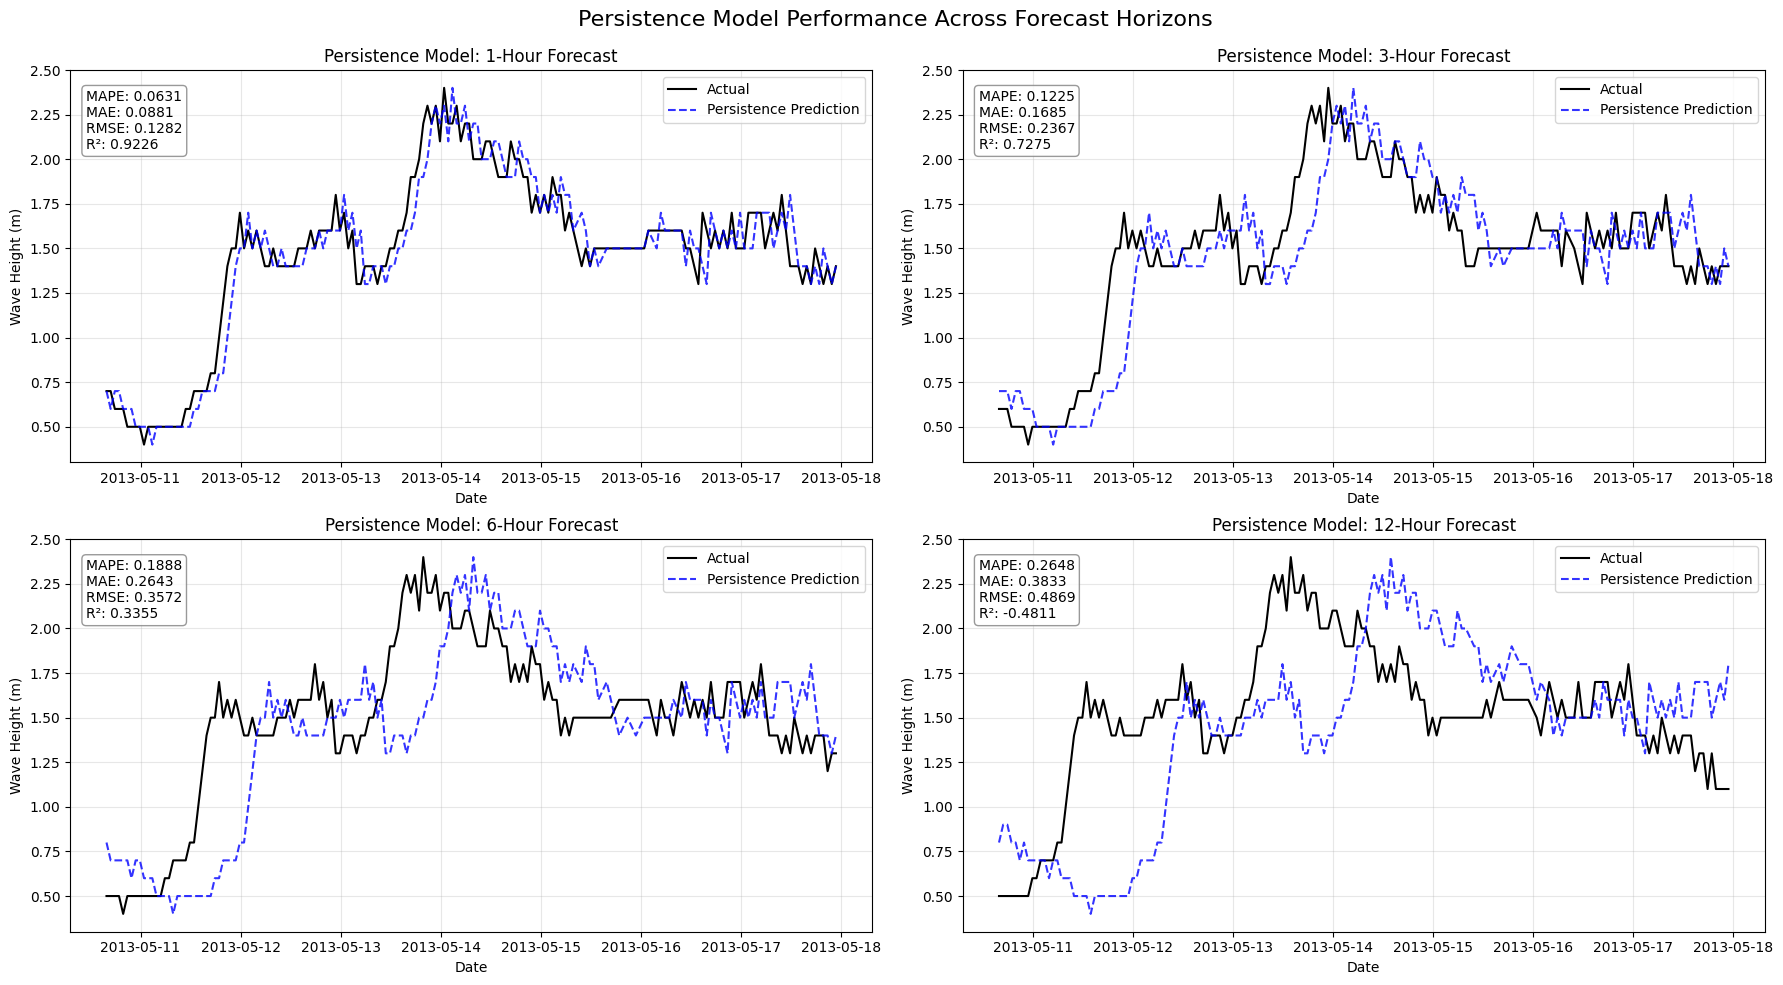

In [8]:
# Create plots for this model
plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2)

for i, h in enumerate(horizons):
    ax = plt.subplot(gs[i])

    # Plot actual vs predicted
    y_true = test[f'target_{h}h']
    y_pred = persistence_preds[f'{h}h']

    # Only plot valid points
    valid_idx = ~y_true.isna() & ~y_pred.isna()
    plt.plot(test.index[valid_idx], y_true[valid_idx], label='Actual', color='black', linewidth=1.5)
    plt.plot(test.index[valid_idx], y_pred[valid_idx], label='Persistence Prediction',
             color='blue', linestyle='--', alpha=0.8)

    # Add metrics box at the top
    m = persistence_metrics[f'{h}h']
    metrics_text = (
        f"MAPE: {m['MAPE']:.4f}\n"
        f"MAE: {m['MAE']:.4f}\n"
        f"RMSE: {m['RMSE']:.4f}\n"
        f"R²: {m['R2']:.4f}"
    )

    plt.text(0.02, 0.95, metrics_text,
             transform=ax.transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3",
                      facecolor='white',
                      alpha=0.8,
                      edgecolor='gray'))

    plt.title(f'Persistence Model: {h}-Hour Forecast')
    plt.xlabel('Date')
    plt.ylabel('Wave Height (m)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Persistence Model Performance Across Forecast Horizons', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

The performance plots and metrics table show that the Persistence model is a strong baseline for very short-term forecasts (1-hour horizon), achieving an R² of 0.92. This is expected in a system with high autocorrelation like wave height. However, its performance degrades sharply as the forecast horizon increases. At the 12-hour horizon, the R² becomes negative (-0.48), indicating that the model's predictions are worse than simply predicting the historical mean of the data. More sophisticated models for longer-term forecasting might perform better.

## Model: SARIMAX

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) is a powerful and widely-used statistical model for time series forecasting. It was chosen for its ability to model three key components intrinsically:

1. **AR (AutoRegressive):** Dependency on past values.

2. **MA (Moving Average):** Dependency on past forecast errors.

3. **S (Seasonal):** Ability to capture seasonal patterns (in this case, a 24-hour daily cycle).

The exogenous regressors (hour_sin, hour_cos) allow the model to incorporate external features. A grid search is performed to find the optimal (p,d,q) and (P,D,Q,m) parameters by minimizing the Akaike Information Criterion (AIC), a standard method for model selection.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore", category=UserWarning)

# Find Best Model Order with a Manual Grid Search
print("Finding best SARIMAX model order with Grid Search...")

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal P, D, and Q triplets
# For hourly data with a daily season, m=24
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model_fit = None

# Define exogenous variables for the model fitting
grid_search_exog = train[['hour_sin', 'hour_cos']]

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            mod = SARIMAX(
                train['significant_wave_height_m'],
                exog=grid_search_exog,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False, maxiter=200)

            # If the current model's AIC is lower than the best one found so far, update
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model_fit = results
                print(f"New best model found: SARIMAX{order}{seasonal_order} -> AIC: {results.aic:.2f}")

        except Exception:
            # Continue if the model fails to fit for any reason
            continue

print(f"\nBest non-seasonal order (p,d,q): {best_order}")
print(f"Best seasonal order (P,D,Q,m): {best_seasonal_order}")
print(f"Best model AIC: {best_aic:.2f}\n")

Finding best SARIMAX model order with Grid Search...
New best model found: SARIMAX(0, 0, 0)(0, 0, 0, 24) -> AIC: 1668.81
New best model found: SARIMAX(0, 0, 0)(0, 0, 1, 24) -> AIC: 1234.82
New best model found: SARIMAX(0, 0, 0)(0, 1, 0, 24) -> AIC: 770.95
New best model found: SARIMAX(0, 0, 0)(0, 1, 1, 24) -> AIC: 723.46
New best model found: SARIMAX(0, 0, 0)(1, 0, 1, 24) -> AIC: 715.69
New best model found: SARIMAX(0, 0, 0)(1, 1, 1, 24) -> AIC: 668.20
New best model found: SARIMAX(0, 0, 1)(0, 1, 0, 24) -> AIC: 337.43
New best model found: SARIMAX(0, 0, 1)(0, 1, 1, 24) -> AIC: 262.16
New best model found: SARIMAX(0, 0, 1)(1, 0, 1, 24) -> AIC: 261.09
New best model found: SARIMAX(0, 0, 1)(1, 1, 1, 24) -> AIC: 234.70
New best model found: SARIMAX(0, 1, 0)(0, 0, 0, 24) -> AIC: -803.99

Best non-seasonal order (p,d,q): (0, 1, 0)
Best seasonal order (P,D,Q,m): (0, 0, 0, 24)
Best model AIC: -803.99



In [10]:
# Perform Rolling Forecast Validation with the Best Model

sarimax_preds = {}
sarimax_metrics = {}

if best_order is not None:  # Proceed only if a best model was found
    # Re-create the test index with hourly frequency
    test_index = pd.date_range(start=test.index.min(), end=test.index.max(), freq='h')
    test = test.reindex(test_index)

    # Generate future exogenous features needed for forecasting beyond the test set
    last_test_date = test.index[-1]
    future_dates = pd.date_range(start=last_test_date + pd.Timedelta(hours=1), periods=max(horizons), freq='h')

    future_exog_df = pd.DataFrame(index=future_dates)
    future_hours = future_exog_df.index.hour
    future_exog_df['hour_sin'] = np.sin(2 * np.pi * future_hours / 24)
    future_exog_df['hour_cos'] = np.cos(2 * np.pi * future_hours / 24)

    # Combine test and future exogenous variables and forward-fill missing values
    extended_exog = pd.concat([test[['hour_sin', 'hour_cos']], future_exog_df])
    extended_exog.ffill(inplace=True)

    for h in horizons:
        print(f"Starting rolling forecast for {h}h horizon:")

        # Combine historical and future data for easy slicing in the loop
        history_endog = list(train['significant_wave_height_m'])
        history_exog = train[['hour_sin', 'hour_cos']].values.tolist()

        predictions = []

        # Loop through each timestamp in the test set
        for i in range(len(test)):
            # Define exogenous variables for the forecast period (h steps ahead)
            forecast_exog = extended_exog.iloc[i : i + h]

            # Fit the SARIMAX model on the entire available history using the best parameters
            model = SARIMAX(
                endog=history_endog,
                exog=history_exog,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            # Fit model, suppressing verbose output
            model_fit = model.fit(disp=False, maxiter=200)

            # Generate the forecast for h steps into the future
            forecast = model_fit.get_forecast(steps=h, exog=forecast_exog)

            # The prediction we need is the last one in the forecast horizon
            prediction_h_step = forecast.predicted_mean[-1]
            predictions.append(prediction_h_step)

            # Update the history with the actual observed value from the test set
            # Use ffill to handle any NaNs from the reindexing
            history_endog.append(test['significant_wave_height_m'].ffill().iloc[i])
            history_exog.append(test[['hour_sin', 'hour_cos']].ffill().iloc[i].values.tolist())

            # Print progress update
            if (i + 1) % 50 == 0:
                print(f"    Forecasted {i + 1}/{len(test)} steps...")

        # Save the predictions for this horizon
        sarimax_preds[f'{h}h'] = pd.Series(predictions, index=test.index)

        # --- 3. Calculate and Store Metrics ---
        y_true = test[f'target_{h}h']
        y_pred = sarimax_preds[f'{h}h']

        # Ensure no NaN values are passed to metric functions
        valid_idx = y_true.notna() & y_pred.notna()

        if valid_idx.sum() > 0:
            sarimax_metrics[f'{h}h'] = {
                'RMSE': np.sqrt(mean_squared_error(y_true[valid_idx], y_pred[valid_idx])),
                'MAE': mean_absolute_error(y_true[valid_idx], y_pred[valid_idx]),
                'R2': r2_score(y_true[valid_idx], y_pred[valid_idx]),
                'MAPE': mean_absolute_percentage_error(y_true[valid_idx], y_pred[valid_idx])
            }
        else:
            sarimax_metrics[f'{h}h'] = {metric: np.nan for metric in ['RMSE', 'MAE', 'R2', 'MAPE']}
else:
    print("SARIMAX grid search did not find a best model. Skipping rolling forecast.")

Starting rolling forecast for 1h horizon:
    Forecasted 50/176 steps...
    Forecasted 100/176 steps...
    Forecasted 150/176 steps...
Starting rolling forecast for 3h horizon:
    Forecasted 50/176 steps...
    Forecasted 100/176 steps...
    Forecasted 150/176 steps...
Starting rolling forecast for 6h horizon:
    Forecasted 50/176 steps...
    Forecasted 100/176 steps...
    Forecasted 150/176 steps...
Starting rolling forecast for 12h horizon:
    Forecasted 50/176 steps...
    Forecasted 100/176 steps...
    Forecasted 150/176 steps...


In [11]:
print("SARIMAX Model Metrics (with Grid Search and Rolling Forecast):")
metrics_df = pd.DataFrame(sarimax_metrics).T
display(metrics_df)

SARIMAX Model Metrics (with Grid Search and Rolling Forecast):


,RMSE,MAE,R2,MAPE
1h,0.128718,0.089353,0.921978,0.064277
3h,0.188884,0.136256,0.826410,0.097822
6h,0.264271,0.189304,0.636353,0.135437
12h,0.380084,0.281604,0.097294,0.190625


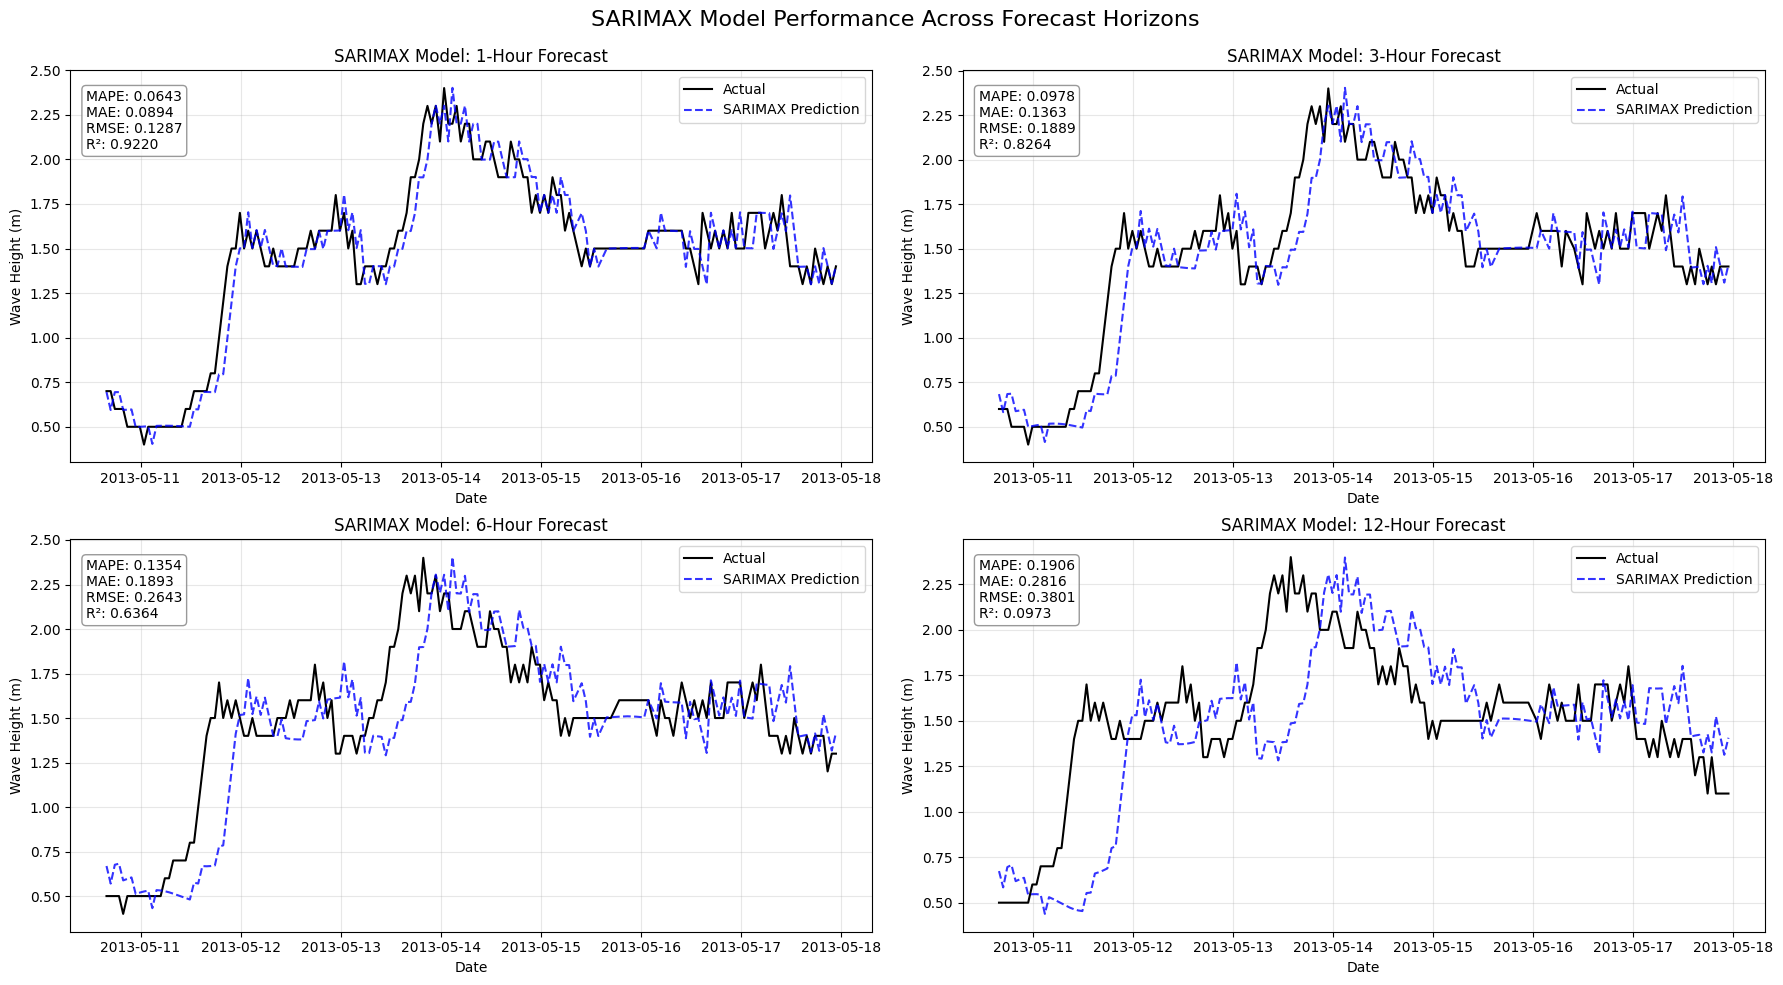

In [12]:
# Create plots for this model
plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2)

for i, h in enumerate(horizons):
    ax = plt.subplot(gs[i])

    # Plot actual vs predicted
    y_true = test[f'target_{h}h']
    y_pred = sarimax_preds[f'{h}h']

    # Align the predictions with the true values
    y_pred = y_pred.reindex(y_true.index)

    # Only plot valid points
    valid_idx = ~y_true.isna() & ~y_pred.isna()
    plt.plot(test.index[valid_idx], y_true[valid_idx], label='Actual', color='black', linewidth=1.5)
    plt.plot(test.index[valid_idx], y_pred[valid_idx], label='SARIMAX Prediction',
             color='blue', linestyle='--', alpha=0.8)

    # Add metrics box at the top
    m = sarimax_metrics[f'{h}h']
    metrics_text = (
        f"MAPE: {m['MAPE']:.4f}\n"
        f"MAE: {m['MAE']:.4f}\n"
        f"RMSE: {m['RMSE']:.4f}\n"
        f"R²: {m['R2']:.4f}"
    )

    plt.text(0.02, 0.95, metrics_text,
             transform=ax.transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3",
                      facecolor='white',
                      alpha=0.8,
                      edgecolor='gray'))

    plt.title(f'SARIMAX Model: {h}-Hour Forecast')
    plt.xlabel('Date')
    plt.ylabel('Wave Height (m)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('SARIMAX Model Performance Across Forecast Horizons', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

The SARIMAX model is the standout performer in this analysis. As it will be seen in the comparative plots below, it consistently achieves the lowest RMSE, MAE, and MAPE across all forecast horizons. At the 12-hour horizon, it is the only model to maintain a positive R² (0.10), demonstrating its ability to capture the underlying structure of the time series for longer-term predictions. Its success is attributable to its inherent design, which uses the full autocorrelation structure of the series, a feature the machine learning models in this script were not explicitly engineered to use.

## Model: RidgeCV

RidgeCV was chosen as a representative linear machine learning model. It performs linear regression with L2 regularization, which helps prevent overfitting by penalizing large coefficient values. The CV (Cross-Validation) component automatically selects the best regularization strength (alpha) from a predefined range. This makes it a simple and effective ML baseline to compare against the statistical and more complex models.

In [13]:
from sklearn.linear_model import RidgeCV

ridge_preds = {}
ridge_metrics = {}
ridge_models = {}

for h in horizons:
    # Features for this horizon
    ridge_feats = [f'lag_{h}h', 'hour_sin', 'hour_cos']

    # Handle NaNs
    train_h = train.ffill()
    test_h = test.ffill()

    # Train model
    ridge = RidgeCV(alphas=np.logspace(-3, 3, 25), scoring='neg_mean_squared_error')
    ridge.fit(train_h[ridge_feats], train_h[f'target_{h}h'])
    ridge_models[f'{h}h'] = ridge

    # Predict
    ridge_preds[f'{h}h'] = pd.Series(
        ridge.predict(test_h[ridge_feats]),
        index=test_h.index
    )

    # Calculate metrics
    valid_idx = ~test_h[f'target_{h}h'].isna()
    y_true = test_h.loc[valid_idx, f'target_{h}h']
    y_pred = ridge_preds[f'{h}h'][valid_idx]

    if len(y_true) > 0:
        ridge_metrics[f'{h}h'] = {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred)
        }
    else:
        ridge_metrics[f'{h}h'] = {metric: np.nan for metric in ['RMSE', 'MAE', 'R2', 'MAPE']}

# Print metrics
print("RidgeCV Model Metrics:")
metrics_df = pd.DataFrame(ridge_metrics).T
display(metrics_df)

RidgeCV Model Metrics:


,RMSE,MAE,R2,MAPE
1h,0.123220,0.087545,0.925208,0.064163
3h,0.224894,0.162805,0.742477,0.123056
6h,0.322297,0.229565,0.434349,0.175235
12h,0.401607,0.314651,-0.054146,0.234545


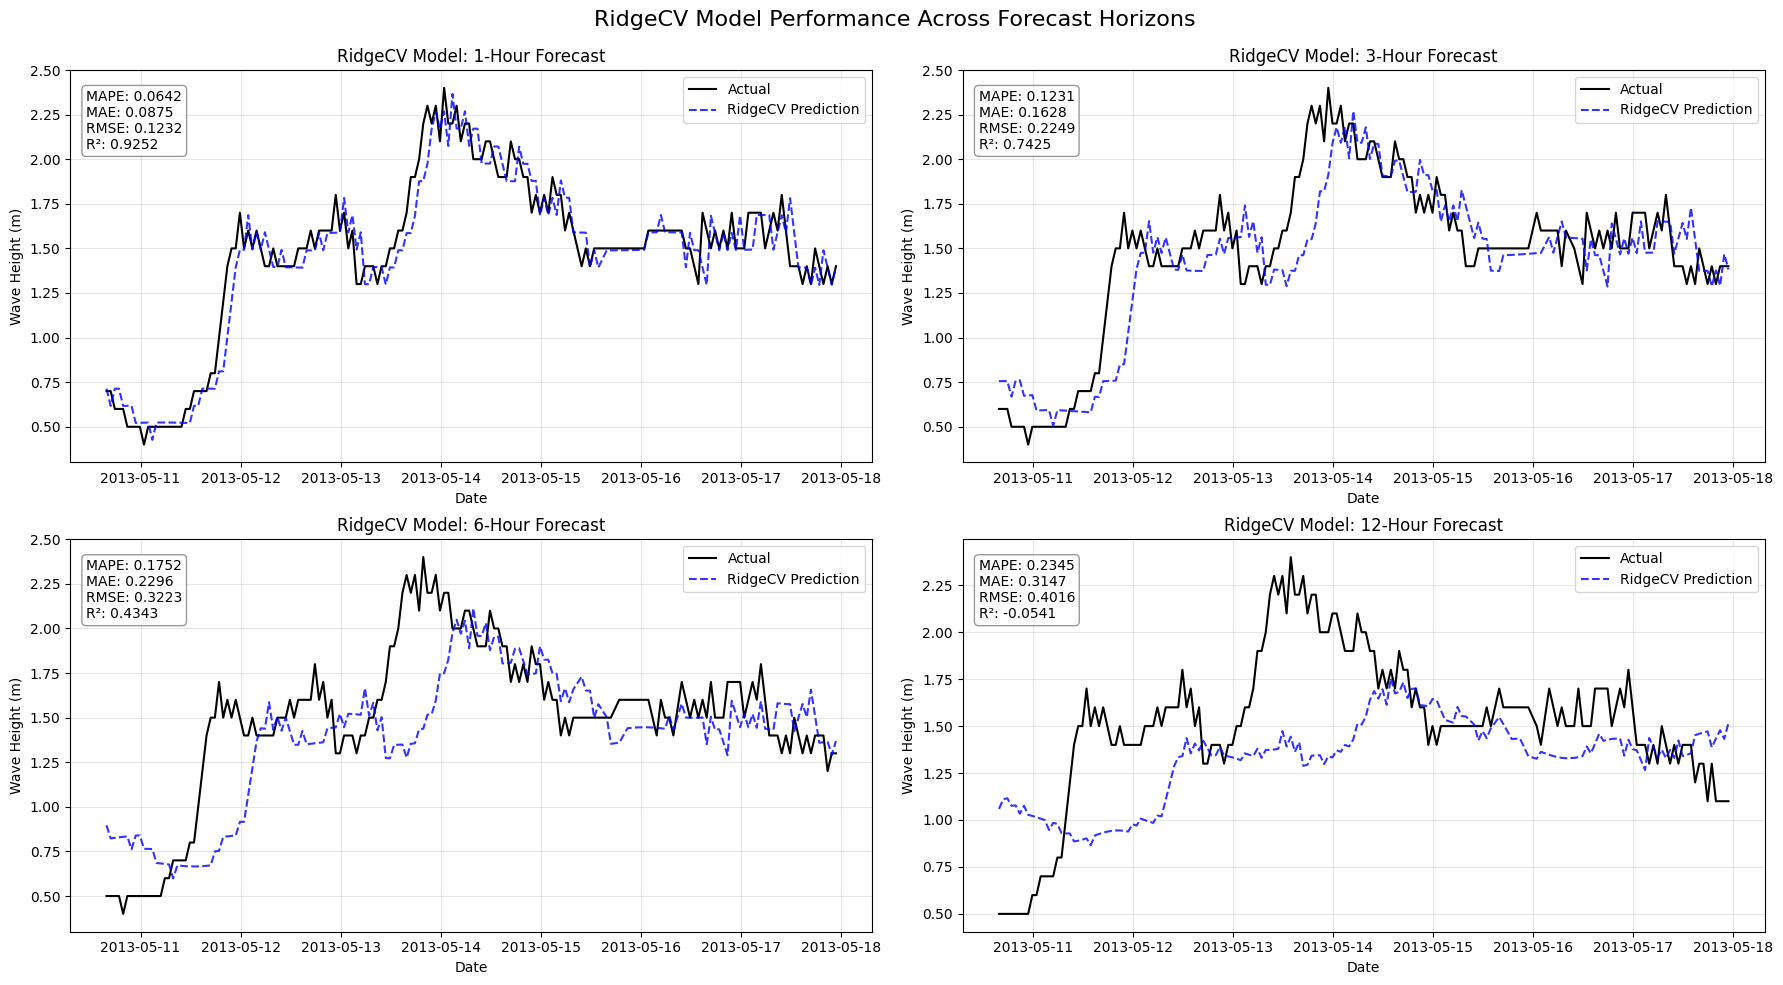

In [14]:
# Create plots for this model
plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2)

for i, h in enumerate(horizons):
    ax = plt.subplot(gs[i])

    # Plot actual vs predicted
    y_true = test[f'target_{h}h']
    y_pred = ridge_preds[f'{h}h']

    # Only plot valid points
    valid_idx = ~y_true.isna() & ~y_pred.isna()
    plt.plot(test.index[valid_idx], y_true[valid_idx], label='Actual', color='black', linewidth=1.5)
    plt.plot(test.index[valid_idx], y_pred[valid_idx], label='RidgeCV Prediction',
             color='blue', linestyle='--', alpha=0.8)

    # Add metrics box at the top
    m = ridge_metrics[f'{h}h']
    metrics_text = (
        f"MAPE: {m['MAPE']:.4f}\n"
        f"MAE: {m['MAE']:.4f}\n"
        f"RMSE: {m['RMSE']:.4f}\n"
        f"R²: {m['R2']:.4f}"
    )

    plt.text(0.02, 0.95, metrics_text,
             transform=ax.transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3",
                      facecolor='white',
                      alpha=0.8,
                      edgecolor='gray'))

    plt.title(f'RidgeCV Model: {h}-Hour Forecast')
    plt.xlabel('Date')
    plt.ylabel('Wave Height (m)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('RidgeCV Model Performance Across Forecast Horizons', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

The RidgeCV model slightly outperforms the Naive Persistence baseline, particularly at the 6 and 12-hour horizons. However, it is consistently outperformed by the SARIMAX model. Its performance is limited because, as a linear model with a very simple feature set, it cannot capture the complex, decaying autocorrelation structure of the time series as effectively as SARIMAX.

## Model: XGBoost

XGBoost (Extreme Gradient Boosting) was selected as a state-of-the-art, non-linear machine learning model. It is an ensemble of decision trees and is renowned for its high performance across a wide range of tabular data problems. It was chosen to test whether a powerful, non-linear algorithm could uncover patterns in the features that the linear and statistical models might miss.

In [15]:
from xgboost import XGBRegressor

xgb_preds = {}
xgb_metrics = {}
xgb_models = {}

for h in horizons:
    xgb_feats = [f'lag_{h}h', 'hour_sin', 'hour_cos']

    # Train model
    xgb = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    xgb.fit(train[xgb_feats], train[f'target_{h}h'])
    xgb_models[f'{h}h'] = xgb

    # Predict
    xgb_preds[f'{h}h'] = pd.Series(
        xgb.predict(test[xgb_feats]),
        index=test.index
    )

    # Calculate metrics
    valid_idx = ~test[f'target_{h}h'].isna()
    y_true = test.loc[valid_idx, f'target_{h}h']
    y_pred = xgb_preds[f'{h}h'][valid_idx]

    if len(y_true) > 0:
        xgb_metrics[f'{h}h'] = {
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred)
        }
    else:
        xgb_metrics[f'{h}h'] = {metric: np.nan for metric in ['RMSE', 'MAE', 'R2', 'MAPE']}

# Print metrics
print("XGBoost Model Metrics:")
metrics_df = pd.DataFrame(xgb_metrics).T
display(metrics_df)

XGBoost Model Metrics:


,RMSE,MAE,R2,MAPE
1h,0.152972,0.112435,0.889803,0.088608
3h,0.271164,0.208168,0.642238,0.153706
6h,0.380002,0.303348,0.248114,0.240262
12h,0.467760,0.383101,-0.367206,0.298928


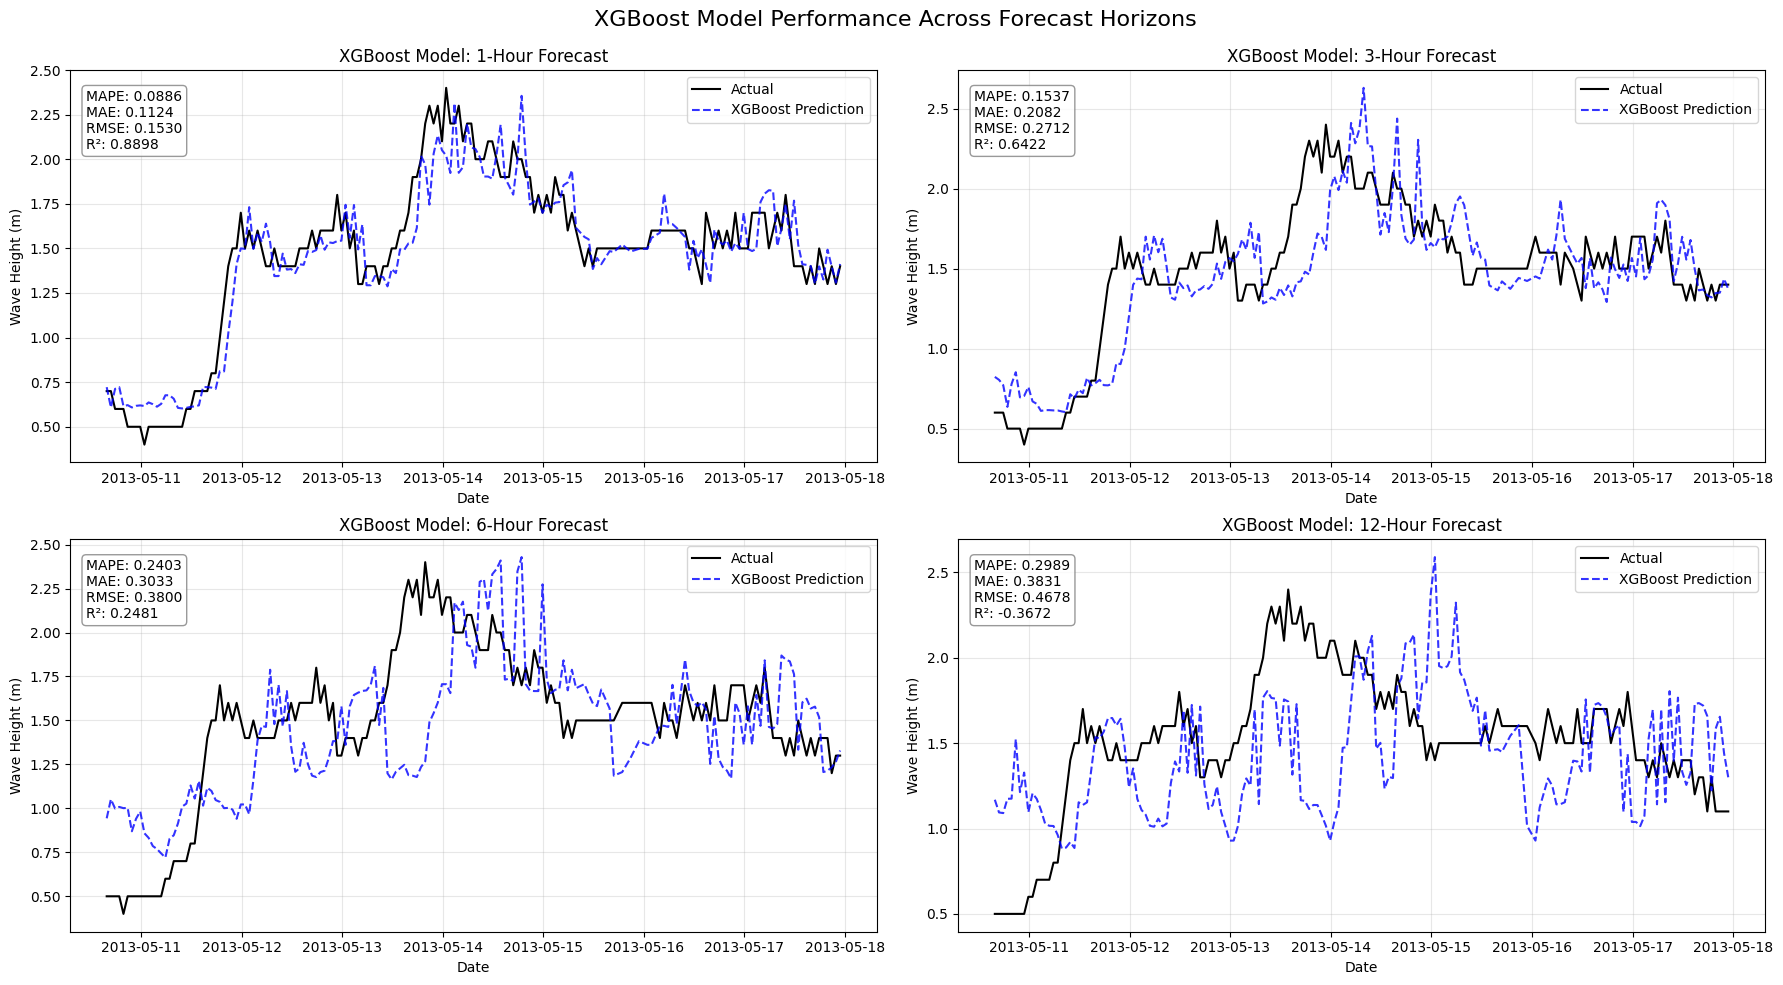

In [16]:
# Create plots for this model
plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 2)

for i, h in enumerate(horizons):
    ax = plt.subplot(gs[i])

    # Plot actual vs predicted
    y_true = test[f'target_{h}h']
    y_pred = xgb_preds[f'{h}h']

    # Only plot valid points
    valid_idx = ~y_true.isna() & ~y_pred.isna()
    plt.plot(test.index[valid_idx], y_true[valid_idx], label='Actual', color='black', linewidth=1.5)
    plt.plot(test.index[valid_idx], y_pred[valid_idx], label='XGBoost Prediction',
             color='blue', linestyle='--', alpha=0.8)

    # Add metrics box at the top
    m = xgb_metrics[f'{h}h']
    metrics_text = (
        f"MAPE: {m['MAPE']:.4f}\n"
        f"MAE: {m['MAE']:.4f}\n"
        f"RMSE: {m['RMSE']:.4f}\n"
        f"R²: {m['R2']:.4f}"
    )

    plt.text(0.02, 0.95, metrics_text,
             transform=ax.transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3",
                      facecolor='white',
                      alpha=0.8,
                      edgecolor='gray'))

    plt.title(f'XGBoost Model: {h}-Hour Forecast')
    plt.xlabel('Date')
    plt.ylabel('Wave Height (m)')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('XGBoost Model Performance Across Forecast Horizons', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

The XGBoost model underperformed compared to all other models, including the Naive Persistence baseline, especially at longer horizons. This result is not indicative of of the XGBoost algorithm's performance itself since the model was not provided enough predictive features. Besides the pre-existing features in the dataset, only the lag at the corresponding horizon and the cyclical time features were added. This single lag provides very little information for longer-term forecasts. To be effective, XGBoost would require a much richer feature set, such as multiple recent lags, rolling statistics, and lags of exogenous variables. However, without enough domain knowledge, simply adding features can result in overfitting too.

## Model Comparison

The comparative plots provide a clear narrative. For 1-hour ahead forecasts, all models perform similarly, indicating the problem is dominated by the most recent observation. As the forecast horizon extends to 3, 6, and 12 hours, the models diverge. The SARIMAX model proves to be superior, maintaining predictive power while the other models' performances degrade rapidly. The R² plot shows at 12 hours, only SARIMAX provides predictions better than a simple mean, while the other models, including XGBoost, have completely broken down.

### Performance Metrics Table

In [17]:
# Consolidate all metrics for comparison
all_metrics = {
    'Persistence': persistence_metrics,
    'SARIMAX': sarimax_metrics,
    'RidgeCV': ridge_metrics,
    'XGBoost': xgb_metrics
}

final_data = {}
for model_name, model_metrics in all_metrics.items():
    for h in horizons:
        metrics = model_metrics[f'{h}h']
        final_data[(model_name, h, '1-MAPE')] = 1 - metrics['MAPE']
        final_data[(model_name, h, '1-RMSE')] = 1 - metrics['RMSE']
        final_data[(model_name, h, 'R2')] = metrics['R2']

final_df = pd.Series(final_data).unstack(level=[1, 2])
display(final_df)

1                             3                       \
               1-MAPE    1-RMSE        R2    1-MAPE    1-RMSE        R2   
Persistence  0.936914  0.871826  0.922635  0.877461  0.763332  0.727472   
RidgeCV      0.935837  0.876780  0.925208  0.876944  0.775106  0.742477   
SARIMAX      0.935723  0.871282  0.921978  0.902178  0.811116  0.826410   
XGBoost      0.911392  0.847028  0.889803  0.846294  0.728836  0.642238   

                   6                             12                      
               1-MAPE    1-RMSE        R2    1-MAPE    1-RMSE        R2  
Persistence  0.811181  0.642762  0.335498  0.735178  0.513149 -0.481084  
RidgeCV      0.824765  0.677703  0.434349  0.765455  0.598393 -0.054146  
SARIMAX      0.864563  0.735729  0.636353  0.809375  0.619916  0.097294  
XGBoost      0.759738  0.619998  0.248114  0.701072  0.532240 -0.367206

### Comparative Plots

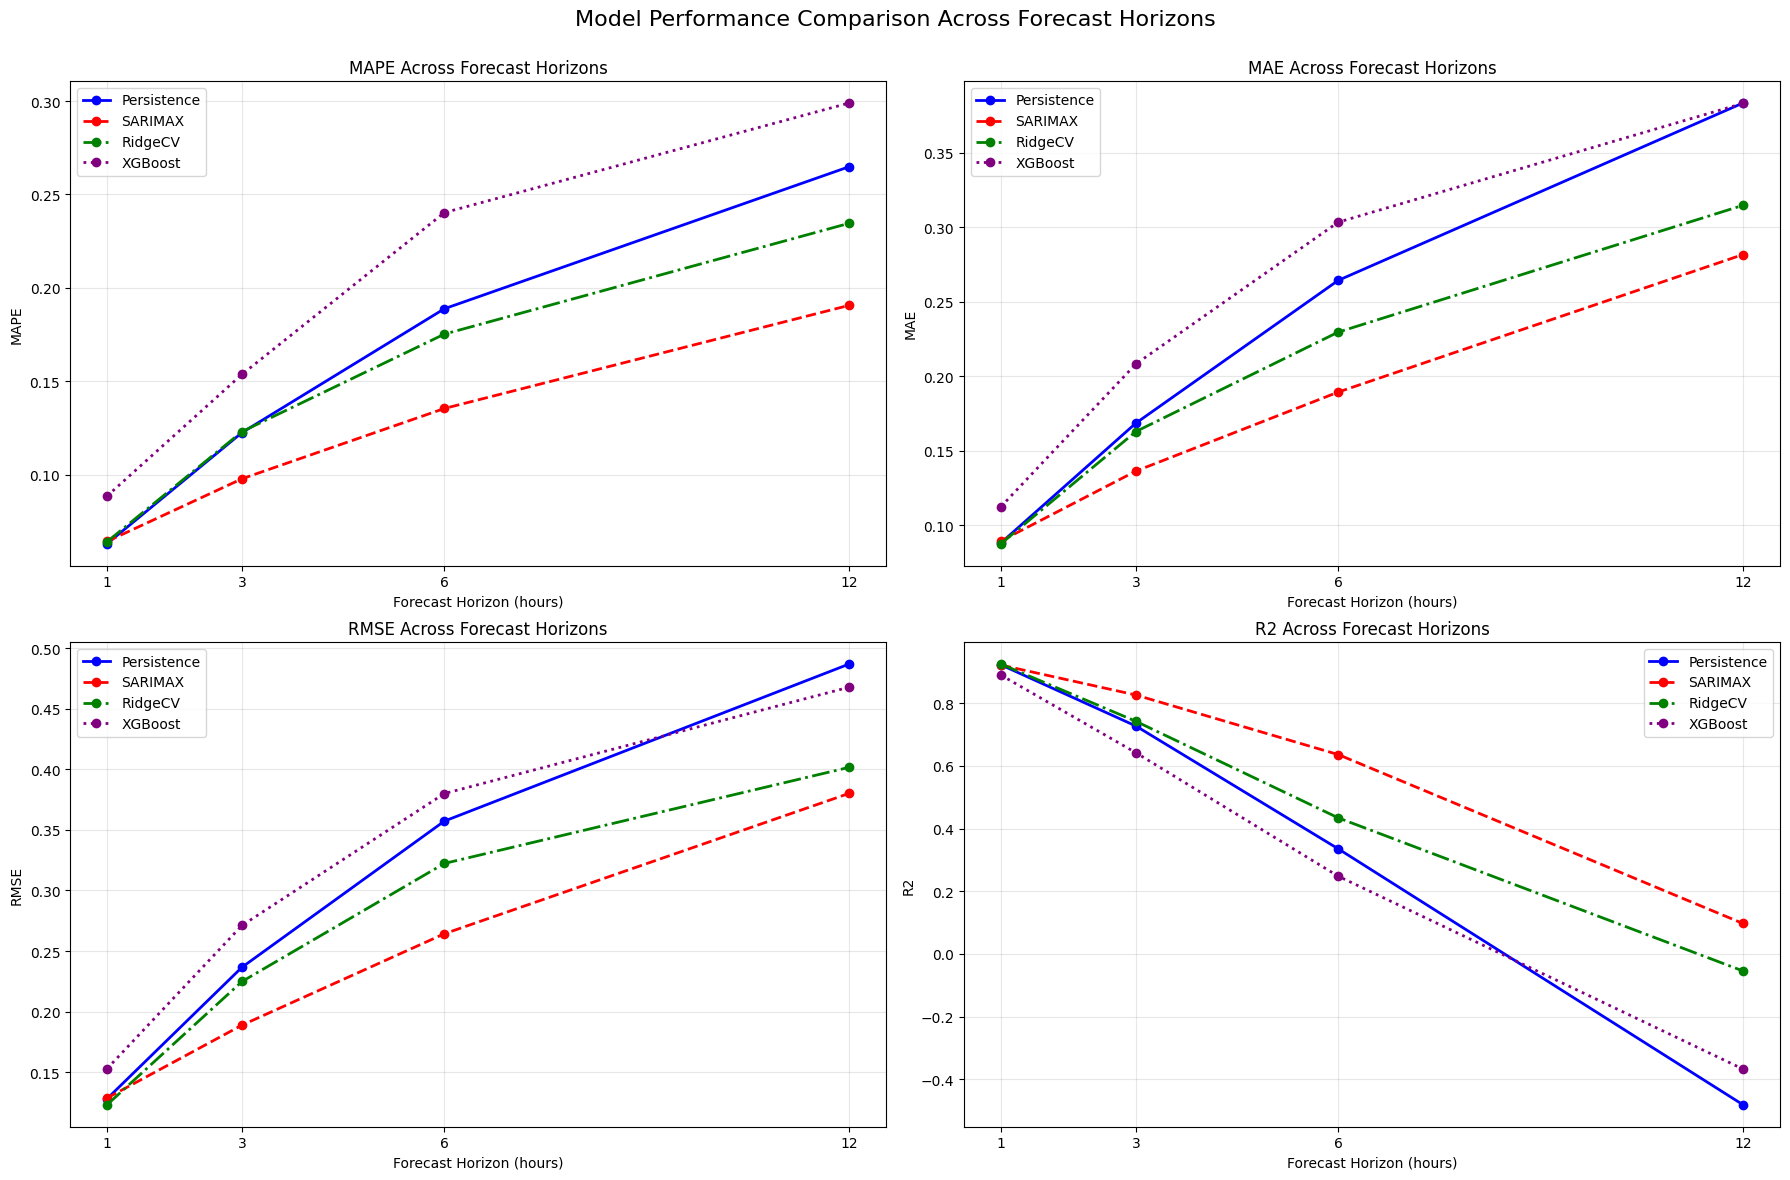

In [18]:
# Create comparative metrics plots
plt.figure(figsize=(18, 12))
metrics_names = ['MAPE', 'MAE', 'RMSE', 'R2']
colors = ['blue', 'red', 'green', 'purple']
linestyles = ['-', '--', '-.', ':']

for i, metric in enumerate(metrics_names):
    plt.subplot(2, 2, i+1)

    for j, (model_name, model_metrics) in enumerate(all_metrics.items()):
        values = [model_metrics[f'{h}h'][metric] for h in horizons]

        plt.plot(horizons, values, marker='o', label=model_name,
                 color=colors[j], linestyle=linestyles[j], linewidth=2)

    plt.xlabel('Forecast Horizon (hours)')
    plt.ylabel(metric)
    plt.title(f'{metric} Across Forecast Horizons')
    plt.xticks(horizons)
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.suptitle('Model Performance Comparison Across Forecast Horizons', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

### Error Metrics Bar Charts

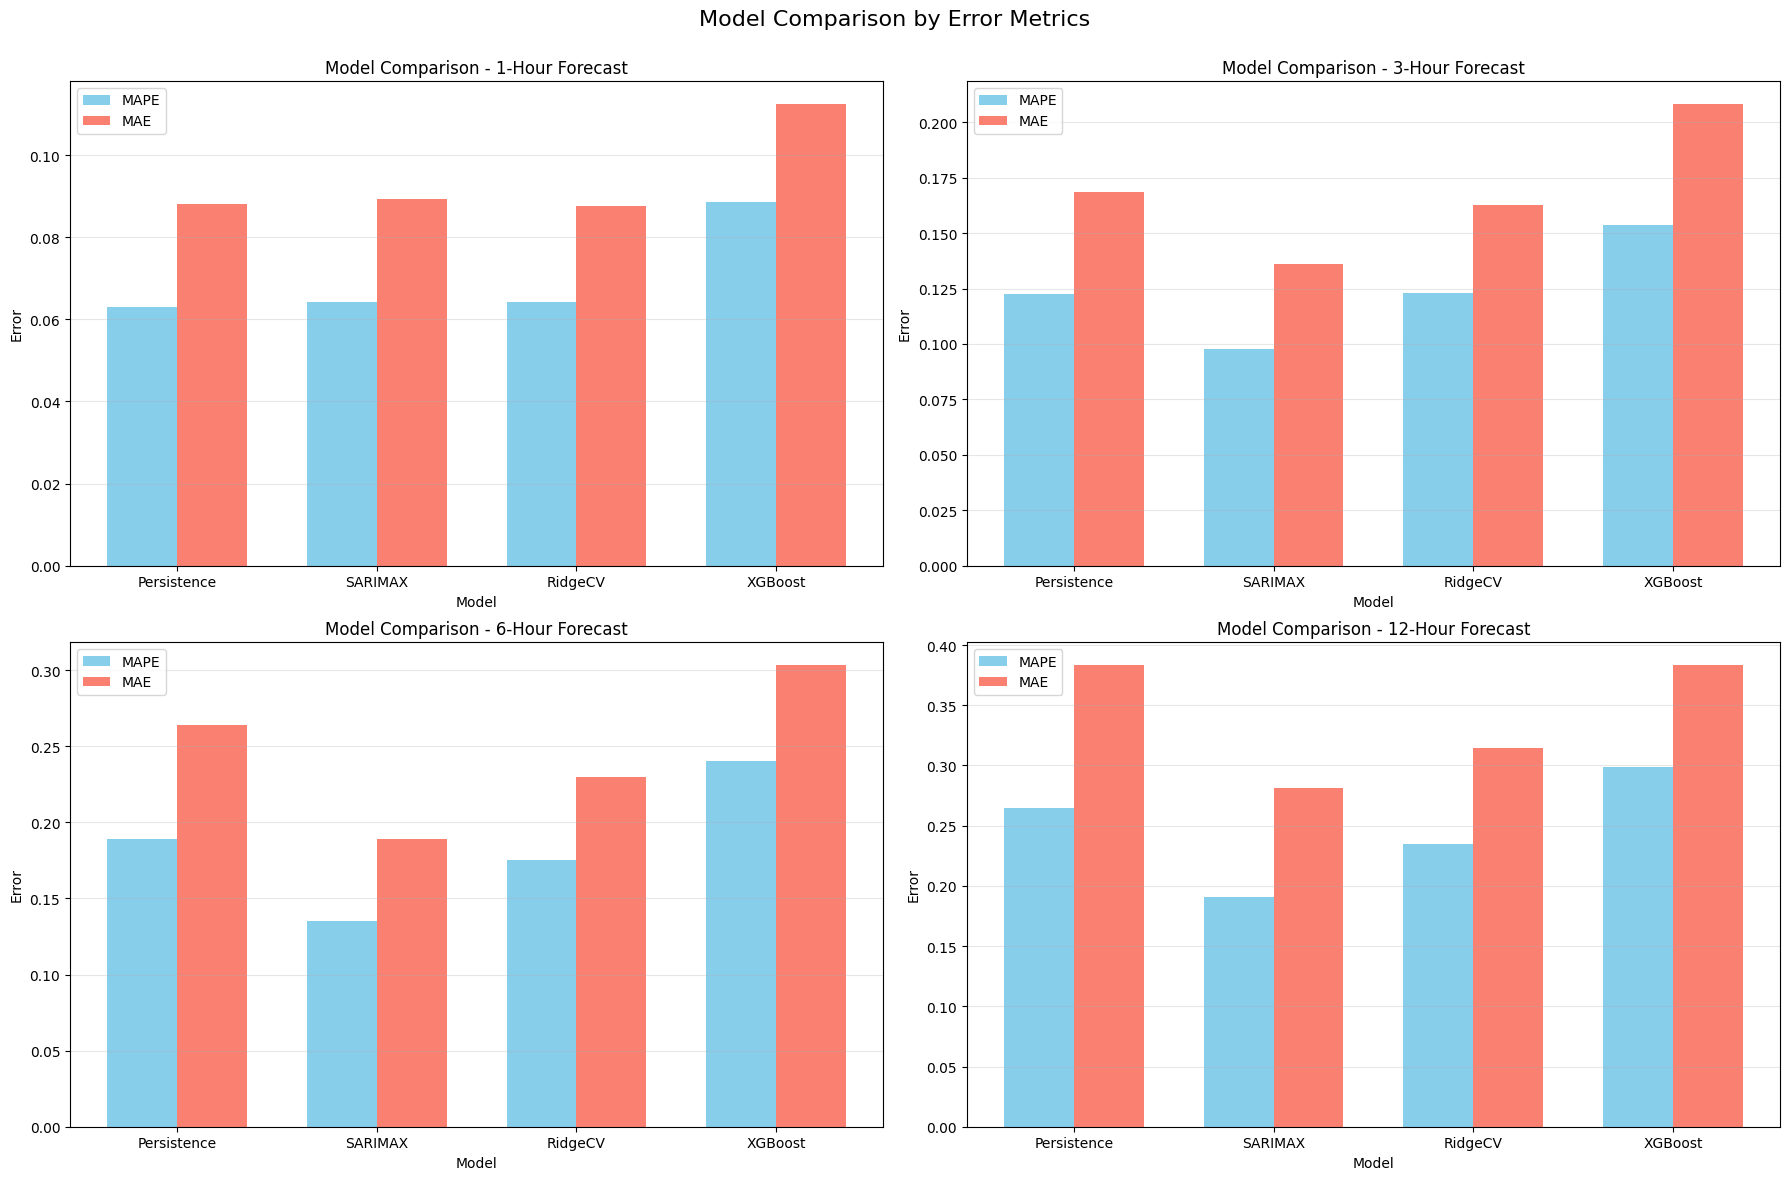

In [19]:
# Create bar charts for each horizon
plt.figure(figsize=(18, 12))

for i, h in enumerate(horizons):
    plt.subplot(2, 2, i+1)

    # Collect metrics for this horizon
    mape_values = [all_metrics[model][f'{h}h']['MAPE'] for model in all_metrics]
    mae_values = [all_metrics[model][f'{h}h']['MAE'] for model in all_metrics]

    # Create bar positions
    x = np.arange(len(all_metrics))
    width = 0.35

    # Plot bars
    plt.bar(x - width/2, mape_values, width, label='MAPE', color='skyblue')
    plt.bar(x + width/2, mae_values, width, label='MAE', color='salmon')

    # Add labels
    plt.xlabel('Model')
    plt.ylabel('Error')
    plt.title(f'Model Comparison - {h}-Hour Forecast')
    plt.xticks(x, all_metrics.keys())
    plt.grid(axis='y', alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.suptitle('Model Comparison by Error Metrics', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

The analysis demonstrates that for a time series forecasting task without extensive feature engineering, a classical statistical model like SARIMAX can significantly outperform even state-of-the-art machine learning models. The success of SARIMAX lies in its built-in mechanisms to handle autocorrelation and seasonality, which are the dominant drivers of the wave height series. The failure of XGBoost highlights a crucial principle that the performance of machine learning models in a time-series context is critically dependent on the creation of a rich feature set that explicitly provides the model with historical context and trends.

## Model Saving

In [ ]:
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Save the best SARIMAX model for each horizon
if 'best_order' in locals() and best_order is not None:
    print("\nTraining and saving a final SARIMAX model for each horizon...")
    for h in horizons:
        print(f"  Training for {h}-hour horizon...")
        
        # Prepare data for this horizon
        train_h = train.dropna(subset=[f'target_{h}h'])
        exog_vars = ['hour_sin', 'hour_cos']
        
        # Define and fit the final model on the full training data
        final_sarimax_model = SARIMAX(
            endog=train_h['significant_wave_height_m'],
            exog=train_h[exog_vars],
            order=best_order,
            seasonal_order=best_seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        final_sarimax_fit = final_sarimax_model.fit(disp=False, maxiter=200)

        # Save the fitted model
        model_path = os.path.join(model_dir, f'sarimax_model_{h}h.pkl')
        final_sarimax_fit.save(model_path)
        print(f"    -> SARIMAX model for {h}h horizon saved to {model_path}")
else:
    print("No best SARIMAX model found, skipping save.")


Training and saving a final SARIMAX model for each horizon...
  Training for 1-hour horizon...
    -> SARIMAX model for 1h horizon saved to saved_models/sarimax_model_1h.pkl
  Training for 3-hour horizon...
    -> SARIMAX model for 3h horizon saved to saved_models/sarimax_model_3h.pkl
  Training for 6-hour horizon...
    -> SARIMAX model for 6h horizon saved to saved_models/sarimax_model_6h.pkl
  Training for 12-hour horizon...
    -> SARIMAX model for 12h horizon saved to saved_models/sarimax_model_12h.pkl


## References

[1] The COMET Program, University Corporation for Atmospheric Research. "Wave Types and Characteristics," MetEd. Accessed: July 20, 2025. [Online]. Available: [https://learn.meted.ucar.edu/](https://learn.meted.ucar.edu/).

[2] J. Perktold, S. Seabold, and J. Taylor, "Statsmodels: Statistical Models and Econometric Tools," Statsmodels.org. Accessed: July 20, 2025. [Online]. Available: [https://www.statsmodels.org/stable/](https://www.statsmodels.org/stable/).

[3] B. Artley, "Time Series Forecasting with ARIMA, SARIMA, and SARIMAX," Towards Data Science, Apr. 26, 2022. Accessed: 20 July 2025. [Online]. Available: [https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6).

[4] R. J. Hyndman and G. Athanasopoulos, *Forecasting: Principles and Practice*, 3rd ed. Melbourne, Australia: OTexts, 2021. Accessed: Jul. 20, 2025. [Online]. Available: [https://otexts.com/fpp3/](https://otexts.com/fpp3/).

[5] H. Hu, A. J. Van Der Westhuysen, P. Chu, and A. Fujisaki-Manome, “Predicting Lake Erie wave heights and periods using XGBoost and LSTM,” Ocean Modelling, vol. 164, p. 101832, Aug. 2021, doi: [10.1016/j.ocemod.2021.101832](https://doi.org/10.1016/j.ocemod.2021.101832).